# Bayesian ARMA model

In [ ]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

This notebook shows how Bayesian [ARMA model](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model#Applications) can be implemeted in **RxInfer.jl**. For theoretical details on Varitional Inference for ARMA model, we refer the reader to the following [paper](https://ieeexplore.ieee.org/document/7798432). The Bayesian ARMA model can be written as follows:


$$\begin{aligned}
e_t \sim \mathcal{N}(0, \gamma^{-1}) \quad
\theta &\sim \mathcal{MN}(\mathbf{0}, \mathbf{I}) \quad
\eta \sim \mathcal{MN}(\mathbf{0}, \mathbf{I}) \\
\mathbf{h}_0 &\sim \mathcal{MN}\left(\begin{bmatrix}
e_{-1} \\
e_{-2}
\end{bmatrix}, \mathbf{I}\right) \\
\mathbf{h}_t &= \mathbf{S}\mathbf{h}_{t-1} + \mathbf{c} e_{t-1} \\
\mathbf{x}_t &= \boldsymbol{\theta}^\top\mathbf{x}_{t-1} + \boldsymbol{\eta}^\top\mathbf{h}_{t} + e_t 
\end{aligned}$$

where shift matrix $\mathbf{S}$ is
$$\begin{aligned}\mathbf{S} = \begin{pmatrix}
0 & 0 \\
1 & 0 
\end{pmatrix}\end{aligned}$$
and unit vector $\mathbf{c}$: $$\begin{aligned}\mathbf{c}=[1, 0]\end{aligned}$$ when MA order is $2$

In this way, $\mathbf{h}_t$ containing errors $e_t$ can be viewed as hidden state.

In short, the Bayesian ARMA model has two intractabilities: (1) induced by the multiplication of two Gaussian RVs, i.e., $\boldsymbol{\eta}^\top\mathbf{h}_{t}$, (2) induced by errors $e_t$ that prevents analytical update of precision parameter $\gamma$ (this can be easily seen when constructing the Factor Graph, i.e. there is a loop). Both problems can be easily resolved in **RxInfer.jl**, by creating a hybrid inference algorithm based on Loopy Variational Message Passing.

In [3]:
# Load packages
using RxInfer, LinearAlgebra, CSV, DataFrames, Plots

In [4]:
# Define shift function
function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [6]:
@model function ARMA(n, x_prev, h_prior, γ_prior, τ_prior, η_prior, θ_prior, p, q)
        
    c = zeros(p); c[1] = 1.0; # AR
    b = zeros(q); b[1] = 1.0; # MA
    S = shift(q); # MA
    
    # initialize variables
    h  = randomvar(n-1)
    e  = randomvar(n)
    z  = randomvar(n)
    
    x  = datavar(Float64, n) where { allow_missing = true }
    
    # priors
    γ  ~ Gamma(shape = shape(γ_prior), rate = rate(γ_prior))
    η  ~ MvNormal(mean = mean(η_prior), precision = precision(η_prior))
    θ  ~ MvNormal(mean = mean(θ_prior), precision = precision(θ_prior))
    τ  ~ Gamma(shape = shape(τ_prior), rate = rate(τ_prior))
    
    # initial
    h_0  ~ MvNormal(mean = mean(h_prior), precision = precision(h_prior))
    z[1] ~ AR(h_0, η, τ) 
    e[1] ~ Normal(mean = 0.0, precision = γ)

    x[1] ~ dot(b, z[1]) + dot(θ, x_prev[1]) + e[1]
    
    h_prev = h_0
    for t in 1:n-1
        
        e[t+1] ~ Normal(mean = 0.0, precision = γ)
        h[t] ~ S*h_prev + b*e[t]
        z[t+1] ~ AR(h[t], η, τ)
        x[t+1] ~ dot(z[t+1], b) + dot(θ, x_prev[t]) + e[t+1]
        h_prev = h[t]
    end
end

### Load dataset

To validate our model and inference, we will use American Airlines stock data downloaded from [Kaggle](https://www.kaggle.com/code/purvasingh/time-series-analysis-with-arma-and-arima/data?select=all_stocks_5yr.csv)

Once the dataset is downloaded, we can load it into DataFrame.

In [7]:
x_df = CSV.read("data/arma/aal_stock.csv", DataFrame)

Row,date,open,high,low,close,volume,Name
,Date,Float64,Float64,Float64,Float64,Int64,String3
1,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
3,2013-02-12,14.45,14.51,14.1,14.27,8126000,AAL
4,2013-02-13,14.3,14.94,14.25,14.66,10259500,AAL
5,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
6,2013-02-15,13.93,14.61,13.93,14.5,15628000,AAL
7,2013-02-19,14.33,14.56,14.08,14.26,11354400,AAL
8,2013-02-20,14.17,14.26,13.15,13.33,14725200,AAL
9,2013-02-21,13.62,13.95,12.9,13.37,11922100,AAL


In [18]:
# we will use "close" column
x_data = filter(!ismissing, x_df[:, 5]);

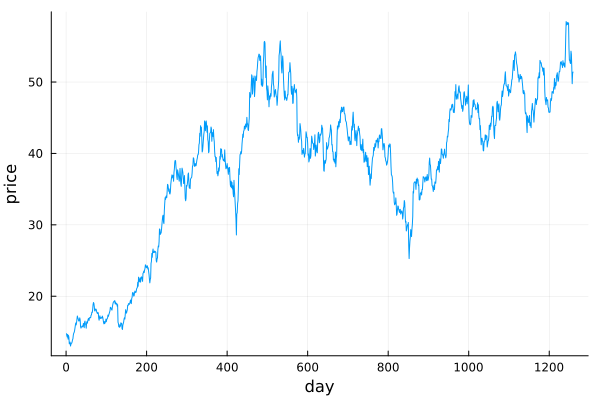

In [19]:
# Plot data
plot(x_data, xlabel="day", ylabel="price", label=false)

In [20]:
p_order = 10 # AR
q_order = 4 # MA

4

In [21]:
# Training set
train_size = 1000
x_prev_train = [Float64.(x_data[i+p_order-1:-1:i]) for i in 1:length(x_data)-p_order][1:train_size]
x_train = Float64.(x_data[p_order+1:end])[1:train_size];

In [22]:
# Test set
x_prev_test = [Float64.(x_data[i+p_order-1:-1:i]) for i in 1:length(x_data)-p_order][train_size+1:end]
x_test = Float64.(x_data[p_order+1:end])[train_size+1:end];

### Inference

In [23]:
# Constraints are needed for performing VMP
arma_constraints = @constraints begin
    q(z, h_0, h, η, τ, γ,e) = q(h_0)q(z, h)q(η)q(τ)q(γ)q(e)
end;

@meta function ARMAmeta(q)
    AR() -> ARMeta(Multivariate, q, ARsafe())
end

ARMAmeta (generic function with 1 method)

In [24]:
h_prior = MvNormalMeanPrecision(zeros(q_order), diageye(q_order))
γ_prior = GammaShapeRate(1e4, 1.0)
τ_prior = GammaShapeRate(1e2, 1.0)
η_prior = MvNormalMeanPrecision(zeros(q_order), diageye(q_order))
θ_prior = MvNormalMeanPrecision(zeros(p_order), diageye(p_order));

In [25]:
arma_imarginals = (h_0 = h_prior, h = h_prior, γ = γ_prior, τ = τ_prior, η = η_prior, θ = θ_prior);
arma_imessages  = (h_0 = h_prior, h = h_prior);

In [27]:
# First execution is slow due to Julia's init compilation 
result = inference(
    model = ARMA(length(x_train), x_prev_train, h_prior, γ_prior, τ_prior, η_prior, θ_prior, p_order, q_order), 
    meta = ARMAmeta(q_order),
    data  = (x = x_train, ),
    free_energy = false, # we are not interested in the free energy in this experiment
    initmarginals = arma_imarginals,
    initmessages  = arma_imessages,
    constraints   = arma_constraints,
    iterations    = 50,
    options       = (limit_stack_depth = 100, ),
);

ErrorException: Multiple proxy vars (Symbol("##nvar#393"), Symbol("##nvar#395")) for variable ##nvar#391 are dissalowed in reference resolution function. This may happened because of the deterministic relation in the model that has more than one random variable as an input. This setting does not play nicely with constraints or meta specification languages. As a workaround create and give a specific name for the output variable of this deterministic relation.

In [ ]:
plot(mean.(result.posteriors[:e][end]), ribbon=std.(result.posteriors[:e][end]))

In [ ]:
# extract posteriors
h_posterior = result.posteriors[:h][end][end]
γ_posterior = result.posteriors[:γ][end]
τ_posterior = result.posteriors[:τ][end]
η_posterior = result.posteriors[:η][end]
θ_posterior = result.posteriors[:θ][end];

In [ ]:
# The prediction function is aimed at approximating the predictive posterior distribution
# It triggers the rules in the generative order (in future, RxInfer.jl will provide this function out of the box)
function prediction(x_prev, h_posterior, γ_posterior, τ_posterior, η_posterior, θ_posterior, p, q)
    h_out = MvNormalMeanPrecision(mean(h_posterior), precision(h_posterior))
    ar_out = @call_rule AR(:y, Marginalisation) (m_x=h_out, q_θ=η_posterior, q_γ=τ_posterior, meta=ARMeta(Multivariate, p, ARsafe()))
    c = zeros(p); c[1] = 1.0
    b = zeros(q); b[1] = 1.0
    ar_dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(b), m_in2=ar_out, meta=ReactiveMP.TinyCorrection())
    θ_out = MvNormalMeanPrecision(mean(θ_posterior), precision(θ_posterior))
    ma_dot_out = @call_rule typeof(dot)(:out, Marginalisation) (m_in1=PointMass(x_prev), m_in2=θ_out, meta=ReactiveMP.TinyCorrection())
    e_out = @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ=PointMass(0.0), q_τ=mean(γ_posterior))
    ar_ma = @call_rule typeof(+)(:out, Marginalisation) (m_in1=ar_dot_out, m_in2=ma_dot_out)  
    @call_rule typeof(+)(:out, Marginalisation) (m_in1=ar_ma, m_in2=e_out)  
end

In [ ]:
predictions = []
for x_prev in x_prev_test
    push!(predictions, prediction(x_prev, h_posterior, γ_posterior, τ_posterior, η_posterior, θ_posterior, p_order, q_order))
    # after every new prediction we can actually "retrain" the model to use the power of Bayesian approach
    # we will skip this part for now
end

In [ ]:
plot(x_test, label="test data", legend=:topleft)
plot!(mean.(predictions)[1:end], ribbon=std.(predictions)[1:end], label="predicted", xlabel="day", ylabel="price")